This notebook is what I'm using to try and collect my thoughts and statistics regarding the models I've utilized for the Board Game Capstone Project. I'd like to look at which games were predicted to be successes, and what the distribution of those games looks like.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.externals import joblib

# Accuracy weighting function used in voting process:
def accuracy_weighting(accuracy, vote):
    """
    Determines the vote of a classifier based on its accuracy and
    previous vote (0 or 1). If the vote was a 1, make it the 
    accuracy value instead. If a 0, do one minus the accuracy.
    """
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

# Load in the dataframe and relevant ensemble model:
with open('BGG_NoNaN_DF.pkl', 'rb') as f:
    noNaN_DF = pickle.load(f)
ratings = noNaN_DF['Rating']
target = ratings.apply(lambda x: x >= 5.84)
features = noNaN_DF.drop(['Rating', 'ID Num', 'User Number', 'Standard Dev'], axis=1)

PKLPATH = 'pkl_files/'
models = []
for i in range(1000):
    models.append(joblib.load('{}rand_forest_ens_oob_nostd{}.pkl'.format(PKLPATH, str(i))))

EOFError: 

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Redo the voting for statistics:
# Separate target into 0s and 1s:
#target.name = 'Target'
#noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
falses_y = falses['Target']
trues_X = trues.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)
falses_X = falses.drop(['Standard Dev', 'ID Num', 'User Number', 'Rating', 'Target'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))

# Revote:
votes = []
for model in models:
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = model.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    accuracy = model.oob_score_
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    votes.append(vote_weighted)

# Calculate the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's double-check the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.7013246688327918

Confusion Matrix: 

[[2298  299]
 [ 896  508]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.72      0.79      3194
       True       0.36      0.63      0.46       807

avg / total       0.78      0.70      0.73      4001



In [19]:
def find_entry(entry, db):
    
    for index, row in db.iterrows():
        if row['Weight'] == entry[0]:
            if row['Min Playtime'] == entry[1]:
                if row['Max Playtime'] == entry[2]:
                    if row['Year Published'] == entry[3]:
                        if row['Min Players'] == entry[4]:
                            if row['Max Players'] == entry[5]:
                                return index
                
    print('FIND_ENTRY: ERROR: No corresponding entry found in the database!')
    return

ensemble_trues = np.where(ensemble_predict==1)[0]
print(len(ensemble_trues))

1404


In [106]:
for ind, entry in enumerate(X_test_folds[ensemble_trues]):
    rating = y_test_folds2[ensemble_trues][ind]
    row = noNaN_DF.loc[(noNaN_DF['Weight'] == entry[0]) & (noNaN_DF['Min Playtime'] == entry[1]) & 
                      (noNaN_DF['Max Playtime'] == entry[2]) & (noNaN_DF['Year Published'] == entry[3]) & 
                      (noNaN_DF['Min Players'] == entry[4]) & (noNaN_DF['Max Players'] == entry[5]) &
                      (noNaN_DF['Rating'] == rating)]
    if len(row) > 1:
        print('dup', ind)
        print(row)

In [107]:
print(row['Rating'], ind)

Shadow War: Armageddon    5.70368
Name: Rating, dtype: float64 1403


In [21]:
true_pred_indices = [find_entry(entry, noNaN_DF) for entry in X_test_folds[ensemble_trues]]
print(len(true_pred_indices))

1404


In [15]:
trues_X.values[0]

array([   4.3485,  240.    ,  240.    , 1986.    ,    3.    ,    5.    ])

In [17]:
X_test_folds[0][0]

2.5172

Now that this is done for the Random Forest Ensemble classifier, I need to do this for SMOTE:

In [23]:
print(true_pred_indices[0:5])
with open('True_pred_indices_randens.pkl', 'wb') as f:
    pickle.dump(true_pred_indices, f)

["Memoir '44: Overlord", 'Anno 1503', 'Im Wandel der Zeiten: Das Würfelspiel – Eisenzeit', 'Mage Knight Board Game', "De Kolonisten van Catan: Historische Scenario's II"]


In [70]:
ratings_true_pred = noNaN_DF['Rating'].loc[true_pred_indices]
print(len(ratings_true_pred))
print(ratings_true_pred.head())

1446
Memoir '44: Overlord                                  6.02389
Anno 1503                                             5.89919
Im Wandel der Zeiten: Das Würfelspiel – Eisenzeit     6.03121
Mage Knight Board Game                                7.91979
De Kolonisten van Catan: Historische Scenario's II    5.96044
Name: Rating, dtype: float64


In [61]:
uniq, uniq_ind, uniq_counts = np.unique(ratings_true_pred.index, return_index=True, return_counts=True)
print(len(np.where(uniq_counts>1)[0]))

59


In [63]:
uniq_before, uniq_ind_before, uniq_counts_before = np.unique(true_pred_indices, 
                                                             return_index=True, return_counts=True)
print(len(np.where(uniq_counts_before>1)[0]))

27


In [67]:
dup_names = uniq_before[np.where(uniq_counts_before>1)[0]]
print(dup_names)
dup_counts = uniq_counts_before[np.where(uniq_counts_before>1)[0]]
print(dup_counts)

['12 Realms: Ancestors Legacy'
 'A Game of Thrones: The Card Game – Mountains of the Moon'
 'Angriff! Teil 1: Ostfront – Karte 6 – Der Sumpf' 'Castell'
 'Conflict of Heroes: Monster Tanks of the Eastern Front'
 'Der Herr der Ringe: Das Kartenspiel – Die Stimme Isengarts'
 'Five Tribes: Galbells' 'Flash Point: Feuer an Bord'
 'Fleet: Salmon License' 'Guerra del Anillo'
 'Kaosball: Team – Shadowvale Ninjas'
 'Kingdom Death: Monster – Flower Knight Expansion' 'Madeira' "Manila '45"
 'Munchkin Jumbo D6' 'Mythic Battles: Expansion II – Tribute of Blood'
 'Nothing Personal: Power & Influence'
 'Order of the Stick Adventure Game: The Shortening'
 'Pathfinder Adventure Card Game: Class Deck – Cleric' 'Plethora'
 'Railways of Great Britain' 'Riverboat'
 'The Dresden Files Cooperative Card Game: Fan Favorites'
 'The Others ‐ Apocalisse' 'The Shared Dream' 'Tybor der Baumeister'
 'Warhammer: Invasion – Arcane Fire']
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 2 2 2]


In [77]:
print(noNaN_DF.drop_duplicates().info())

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, Die Macher to Backyard Builders Treehouse
Data columns (total 11 columns):
ID Num            19999 non-null int64
Rating            19999 non-null float64
Standard Dev      19999 non-null float64
Weight            19999 non-null float64
User Number       19999 non-null float64
Min Playtime      19999 non-null float64
Max Playtime      19999 non-null float64
Year Published    19999 non-null float64
Min Players       19999 non-null float64
Max Players       19999 non-null float64
Target            19999 non-null bool
dtypes: bool(1), float64(9), int64(1)None


In [83]:
print(len(X_test_true), len(X_test_false))
print(len(X_test_folds))
print(len(np.where(ensemble_predict==1)[0]), len(np.where(ensemble_predict==0)[0]))

807 3194
4001
1404 2597


In [103]:
print(ratings.max(), ratings.min())

8.01081 5.15607


In [123]:
np.percentile(noNaN_DF.Rating, 10)

5.487886

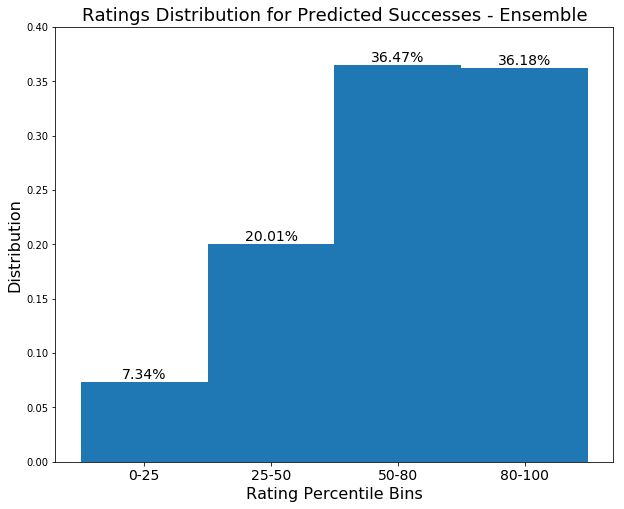

In [118]:
hist = np.histogram(ratings, bins=(5,5.524,5.581,5.84,8.1))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(4), percents, width=1)
xticks = ['0-25', '25-50', '50-80', '80-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.4])
_ = plt.title('Ratings Distribution for Predicted Successes - Ensemble', fontsize=18)
plt.show()

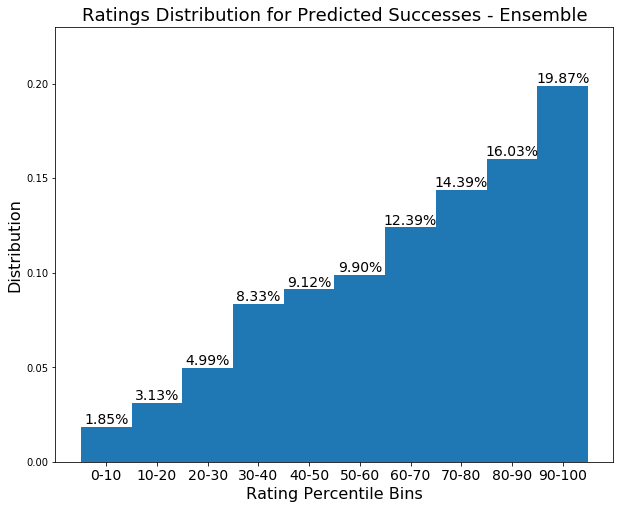

In [143]:
hist = np.histogram(ratings, bins=(np.percentile(noNaN_DF.Rating, 0),np.percentile(noNaN_DF.Rating, 10),
                                   np.percentile(noNaN_DF.Rating, 20),np.percentile(noNaN_DF.Rating, 30),
                                   np.percentile(noNaN_DF.Rating, 40),np.percentile(noNaN_DF.Rating, 50),
                                   np.percentile(noNaN_DF.Rating, 60),np.percentile(noNaN_DF.Rating, 70),
                                   np.percentile(noNaN_DF.Rating, 80),np.percentile(noNaN_DF.Rating, 90),
                                   np.percentile(noNaN_DF.Rating, 100)))
percents = hist[0]/np.sum(hist[0])
fig, axes = plt.subplots(figsize=(10,8))
#_ = axes.hist(ratings_true_pred, bins=[5,5.524,5.581,5.84,8.1])
rects = axes.bar(range(0,40,4), percents, width=4)
xticks = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80',
          '80-90', '90-100']
for rect in rects:
    height = float(rect.get_height())
    _ = axes.text(rect.get_x() + rect.get_width()/2., 1.001*height,
                '{:.2f}%'.format(height*100), ha='center', va='bottom', size=14)
_ = plt.xticks(np.arange(0,40,4), xticks, size=14)
_ = axes.set_xlabel('Rating Percentile Bins', fontsize=16)
_ = axes.set_ylabel('Distribution', fontsize=16)
_ = axes.set_ylim([0.0, 0.23])
_ = plt.title('Ratings Distribution for Predicted Successes - Ensemble', fontsize=18)
plt.show()

In [132]:
print(len(ratings))

1404


In [125]:
print(hist)

(array([ 26,  44,  70, 117, 128, 139, 174, 202, 225, 279]), array([3.72941 , 5.487886, 5.514366, 5.53531 , 5.55643 , 5.58109 ,
       5.620624, 5.690596, 5.843072, 6.199534, 8.62263 ]))


In [95]:
trues_y2 = trues['Rating']
falses_y2 = falses['Rating']
X_train_true2, X_test_true2, y_train_true2, y_test_true2 = train_test_split(trues_X.values, 
                                                    trues_y2.values, test_size=0.2, random_state=42)
X_train_false2, X_test_false2, y_train_false2, y_test_false2 = train_test_split(falses_X.values, 
                                                    falses_y2.values, test_size=0.2, random_state=42)
X_test_folds2 = np.concatenate((X_test_true2, X_test_false2))
y_test_folds2 = np.concatenate((y_test_true2, y_test_false2))

In [99]:
print(len(X_test_folds2), len(X_test_folds))
np.array_equal(X_test_folds, X_test_folds2)

4001 4001


True

In [100]:
ratings = y_test_folds2[ensemble_trues]

In [101]:
len(ratings)

1404

In [102]:
ratings

array([6.02389, 5.89919, 6.03121, ..., 5.53454, 5.70789, 5.70368])

In [3]:
import seaborn as sns
true_recall = np.array([0.66,0.67,0.68,0.61,0.59,0.66,0.65,0.66,0.64,0.63])
false_recall = np.array([0.65,0.64,0.64,0.69,0.69,0.69,0.70,0.69,0.71,0.72])
avg_recall = np.array([0.65,0.65,0.65,0.67,0.67,0.69,0.69,0.68,0.69,0.70])
labels = np.array(['logreg_SMOTE_reg', 'logreg_SMOTE_borderline1', 'logreg_SMOTE_borderline2',
                  'logreg_SMOTE_svm', 'logreg_Ensemble', 'randfor_SMOTE_reg','randfor_SMOTE_borderline1',
                  'randfor_SMOTE_borderline2', 'randfor_SMOTE_svm', 'randfor_Emsemble'])

In [6]:
data = {'True Recall': true_recall, 'False Recall': false_recall, 'Average Recall': avg_recall, 'Labels': labels}
results_df = pd.DataFrame.from_dict(data=data)

In [7]:
results_df.head()

,Average Recall,False Recall,Labels,True Recall
0,0.65,0.65,logreg_SMOTE_reg,0.66
1,0.65,0.64,logreg_SMOTE_borderline1,0.67
2,0.65,0.64,logreg_SMOTE_borderline2,0.68
3,0.67,0.69,logreg_SMOTE_svm,0.61
4,0.67,0.69,logreg_Ensemble,0.59


In [11]:
new_df = pd.melt(results_df, id_vars=['Labels'], value_name='value')

In [20]:
new_df.head(30)

,Labels,variable,value
0,logreg_SMOTE_reg,Average Recall,0.65
1,logreg_SMOTE_borderline1,Average Recall,0.65
2,logreg_SMOTE_borderline2,Average Recall,0.65
3,logreg_SMOTE_svm,Average Recall,0.67
4,logreg_Ensemble,Average Recall,0.67
5,randfor_SMOTE_reg,Average Recall,0.69
6,randfor_SMOTE_borderline1,Average Recall,0.69
7,randfor_SMOTE_borderline2,Average Recall,0.68
8,randfor_SMOTE_svm,Average Recall,0.69
9,randfor_Emsemble,Average Recall,0.70


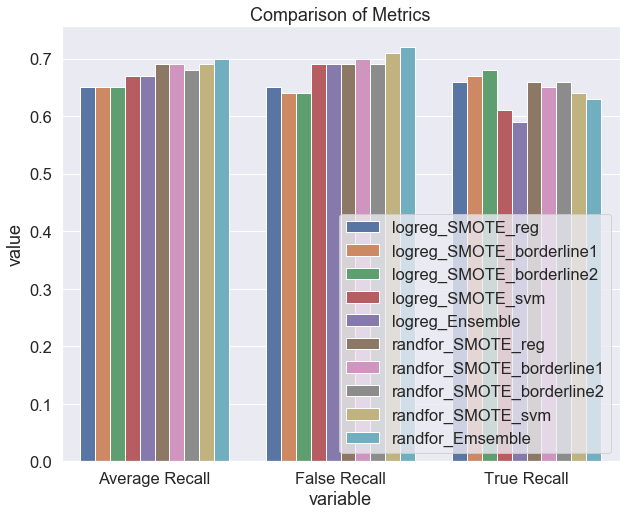

In [30]:
fig, axes = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.5)
_ = sns.barplot(x='variable', y='value', hue='Labels', data=new_df)
_ = plt.title('Comparison of Metrics')
_ = plt.legend(loc='lower right')
plt.show()

In [44]:
dict2 = {'Percentile Bins': np.array(['0-25', '25-50', '50-80', '80-100']), 
         'SMOTE': np.array([6.06, 19.02, 38.51, 36.42]), 
         'Ensemble': np.array([6.38, 20.19, 37.88, 35.54])}
dist_df = pd.DataFrame.from_dict(data=dict2)

In [45]:
dist2 = pd.melt(dist_df, id_vars=['Percentile Bins'])
dist2.head(8)

,Percentile Bins,variable,value
0,0-25,Ensemble,6.38
1,25-50,Ensemble,20.19
2,50-80,Ensemble,37.88
3,80-100,Ensemble,35.54
4,0-25,SMOTE,6.06
5,25-50,SMOTE,19.02
6,50-80,SMOTE,38.51
7,80-100,SMOTE,36.42


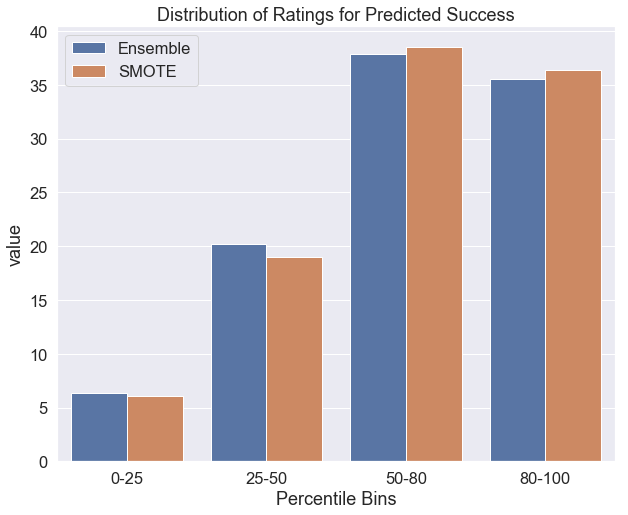

In [48]:
fig, axes = plt.subplots(figsize=(10,8))
_ = sns.barplot(x='Percentile Bins', y='value', hue='variable', data=dist2)
_ = plt.title('Distribution of Ratings for Predicted Success')
_ = plt.legend(loc='upper left')
plt.show()

In [49]:
dict3 = {'Percentile Bins': np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']), 
         'SMOTE': np.array([1.25,3.03,3.97,7.00,9.82,11.23,12.59,14.68,15.26,21.16]), 
         'Ensemble': np.array([1.45,2.75,4.44,7.59,10.34,11.07,12.76,14.05,15.19,20.36])}
dist_df2 = pd.DataFrame.from_dict(data=dict3)

In [50]:
dist3 = pd.melt(dist_df2, id_vars=['Percentile Bins'])
dist3.head(8)

,Percentile Bins,variable,value
0,0-10,Ensemble,1.45
1,10-20,Ensemble,2.75
2,20-30,Ensemble,4.44
3,30-40,Ensemble,7.59
4,40-50,Ensemble,10.34
5,50-60,Ensemble,11.07
6,60-70,Ensemble,12.76
7,70-80,Ensemble,14.05


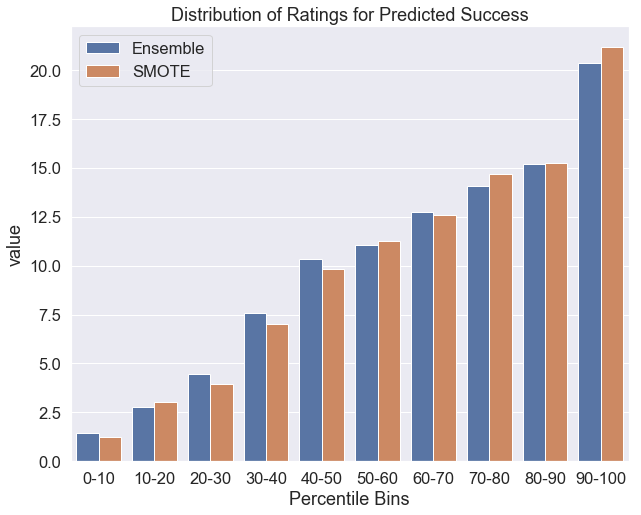

In [51]:
fig, axes = plt.subplots(figsize=(10,8))
_ = sns.barplot(x='Percentile Bins', y='value', hue='variable', data=dist3)
_ = plt.title('Distribution of Ratings for Predicted Success')
_ = plt.legend(loc='upper left')
plt.show()